# Day 57: Long Short-Term Memory (LSTM) Networks

## Introduction

Welcome to Day 57 of our 100 Days of Machine Learning journey! Today, we dive into one of the most important architectures in deep learning for sequence modeling: **Long Short-Term Memory (LSTM) networks**.

While traditional Recurrent Neural Networks (RNNs) can theoretically capture long-term dependencies in sequential data, they struggle with the **vanishing gradient problem**, which makes it difficult to learn patterns that span many time steps. LSTMs were specifically designed to address this limitation, making them highly effective for tasks involving sequences such as time series prediction, natural language processing, speech recognition, and more.

### Why LSTMs Matter

Sequential data is everywhere:
- **Text**: Words in a sentence depend on previous words for context
- **Time Series**: Stock prices, weather patterns, sensor readings
- **Audio**: Speech and music have temporal structure
- **Video**: Frames are sequential and temporally related

LSTMs excel at learning from such data because they can:
1. Remember important information over long sequences
2. Forget irrelevant information
3. Selectively update their internal state

### Learning Objectives

By the end of this lesson, you will be able to:
- Understand the LSTM architecture and how it differs from vanilla RNNs
- Explain the role of the three gates: forget gate, input gate, and output gate
- Implement LSTM networks using TensorFlow/Keras
- Apply LSTMs to sequence prediction problems
- Visualize LSTM training performance and predictions

## Theory: Understanding LSTM Architecture

### The Vanishing Gradient Problem

Before we dive into LSTMs, let's understand the problem they solve. In vanilla RNNs, when we backpropagate through many time steps, gradients can become exponentially small (vanishing gradients) or exponentially large (exploding gradients). This makes it extremely difficult to learn long-term dependencies.

For a vanilla RNN, the hidden state is updated as:

$$h_t = \tanh(W_{hh}h_{t-1} + W_{xh}x_t + b_h)$$

When backpropagating through $T$ time steps, gradients involve repeated multiplication of the weight matrix $W_{hh}$. If the largest eigenvalue of $W_{hh}$ is less than 1, gradients vanish; if greater than 1, they explode.

### LSTM Architecture

LSTMs solve this problem through a carefully designed architecture with **gates** that control information flow. An LSTM cell has two states:

1. **Cell State** ($c_t$): The "memory" of the network, which can carry information across many time steps
2. **Hidden State** ($h_t$): The output of the LSTM cell at time $t$

### The Three Gates

LSTMs use three gates to control the cell state:

#### 1. Forget Gate ($f_t$)

The forget gate decides what information to discard from the cell state:

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

where $\sigma$ is the sigmoid function that outputs values between 0 and 1:
- $f_t = 0$: Completely forget
- $f_t = 1$: Completely keep

#### 2. Input Gate ($i_t$)

The input gate decides what new information to store in the cell state:

$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$

$$\tilde{c}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c)$$

where $\tilde{c}_t$ represents candidate values that could be added to the cell state.

#### 3. Output Gate ($o_t$)

The output gate decides what information to output based on the cell state:

$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$

### Cell State Update

The cell state is updated by:
1. Forgetting some information: $f_t \odot c_{t-1}$
2. Adding new information: $i_t \odot \tilde{c}_t$

$$c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$$

where $\odot$ denotes element-wise multiplication.

### Hidden State Update

Finally, the hidden state (output) is computed:

$$h_t = o_t \odot \tanh(c_t)$$

### Why LSTMs Work

The key insight is that the cell state $c_t$ has a direct path through time with only element-wise operations. Gradients can flow backward through this path with minimal modification, allowing the network to learn long-term dependencies. The gates learn to regulate this flow, deciding what information is relevant and what should be forgotten.

## Python Implementation

Let's implement LSTM networks using TensorFlow and Keras. We'll start with necessary imports:

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

2025-11-09 11:56:43.973707: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-09 11:56:43.974194: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 11:56:44.067935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-11-09 11:56:48.446715: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 11:56:48.462353: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0
NumPy version: 2.3.4


### Example 1: Simple Sequence Prediction

Let's start with a simple example: predicting a sine wave. This is a classic problem for demonstrating LSTM capabilities.

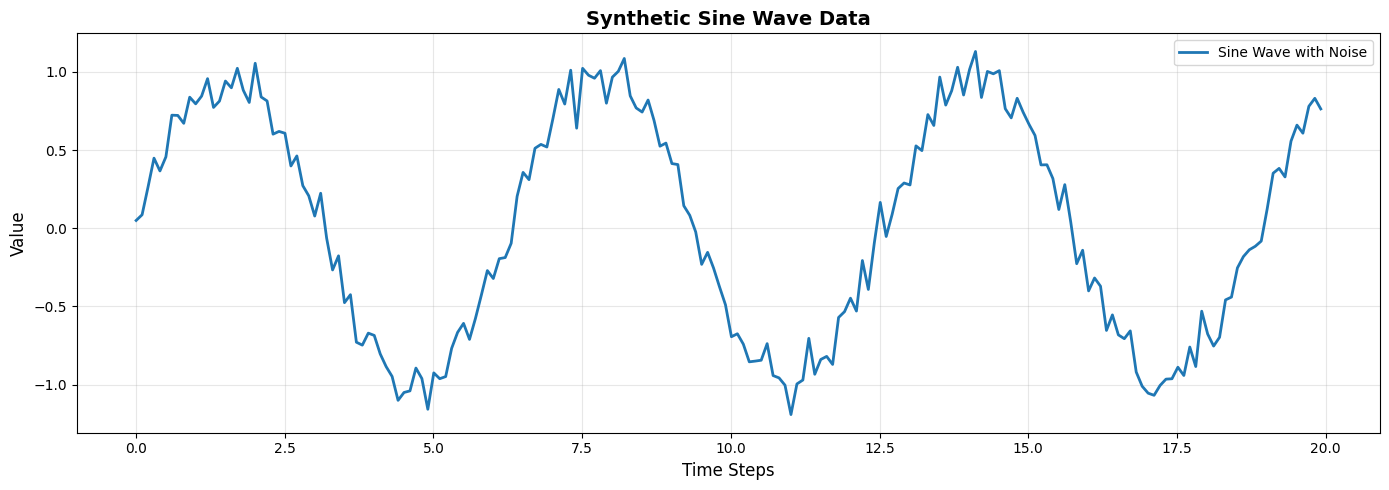

Data shape: (1000,)
Data range: [-1.20, 1.26]


In [2]:
# Generate synthetic sine wave data
def generate_sine_wave(n_samples=1000, n_steps=50):
    """
    Generate sine wave data for training LSTM
    
    Args:
        n_samples: Total number of time steps
        n_steps: Number of time steps in each sequence
    """
    # Create time steps
    t = np.linspace(0, 100, n_samples)
    
    # Generate sine wave with some noise
    data = np.sin(t) + 0.1 * np.random.randn(n_samples)
    
    return data, t

# Generate data
data, time_steps = generate_sine_wave(n_samples=1000)

# Visualize the sine wave
plt.figure(figsize=(14, 5))
plt.plot(time_steps[:200], data[:200], label='Sine Wave with Noise', linewidth=2)
plt.title('Synthetic Sine Wave Data', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Data shape: {data.shape}")
print(f"Data range: [{data.min():.2f}, {data.max():.2f}]")

### Data Preparation for LSTM

LSTMs require data to be formatted as sequences. We need to create sequences where:
- **X**: Input sequences of length `n_steps`
- **y**: The next value in the sequence

For example, if `n_steps=10`:
- X[0] = [data[0], data[1], ..., data[9]]
- y[0] = data[10]

In [3]:
def create_sequences(data, n_steps):
    """
    Create sequences for LSTM training
    
    Args:
        data: 1D array of time series data
        n_steps: Number of time steps in each input sequence
    
    Returns:
        X: Input sequences of shape (n_samples, n_steps, 1)
        y: Target values of shape (n_samples,)
    """
    X, y = [], []
    
    for i in range(len(data) - n_steps):
        # Get sequence of n_steps
        seq = data[i:i + n_steps]
        # Get the next value as target
        target = data[i + n_steps]
        
        X.append(seq)
        y.append(target)
    
    X = np.array(X)
    y = np.array(y)
    
    # Reshape X to (samples, time steps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    return X, y

# Create sequences
n_steps = 50  # Use 50 time steps to predict the next value
X, y = create_sequences(data, n_steps)

# Split into train and test sets (80-20 split)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training sequences: {X_train.shape}")
print(f"Training targets: {y_train.shape}")
print(f"Test sequences: {X_test.shape}")
print(f"Test targets: {y_test.shape}")
print(f"\nExample input sequence shape: {X_train[0].shape}")
print(f"Example input sequence (first 10 values):\n{X_train[0][:10].flatten()}")
print(f"Corresponding target: {y_train[0]:.4f}")

Training sequences: (760, 50, 1)
Training targets: (760,)
Test sequences: (190, 50, 1)
Test targets: (190,)

Example input sequence shape: (50, 1)
Example input sequence (first 10 values):
[0.04967142 0.08610659 0.26363439 0.44811007 0.36637177 0.45645101
 0.72305935 0.72149693 0.67096635 0.83814261]
Corresponding target: -0.9251


### Building the LSTM Model

Now let's build an LSTM model using Keras. We'll create a simple architecture with:
- An LSTM layer with 50 units
- A Dropout layer for regularization
- A Dense output layer

In [4]:
def build_lstm_model(input_shape, units=50, dropout_rate=0.2):
    """
    Build an LSTM model for sequence prediction
    
    Args:
        input_shape: Shape of input sequences (time steps, features)
        units: Number of LSTM units
        dropout_rate: Dropout rate for regularization
    
    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # LSTM layer
        LSTM(units=units, activation='tanh', input_shape=input_shape, 
             return_sequences=False),
        
        # Dropout for regularization
        Dropout(dropout_rate),
        
        # Output layer
        Dense(1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (n_steps, n_features)
model = build_lstm_model(input_shape, units=50, dropout_rate=0.2)

# Display model architecture
print("LSTM Model Architecture:")
print("=" * 60)
model.summary()

# Calculate total parameters
trainable_params = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"\nTotal trainable parameters: {trainable_params:,}")

LSTM Model Architecture:


2025-11-09 11:56:50.589043: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 10,451


### Understanding LSTM Parameters

Notice the number of parameters in the LSTM layer. For an LSTM with:
- `n_features` input features (1 in our case)
- `units` LSTM units (50 in our case)

The number of parameters is calculated as:

$$\text{params} = 4 \times (\text{units} \times (\text{units} + \text{n\_features}) + \text{units})$$

The factor of 4 comes from the four components: forget gate, input gate, output gate, and cell state candidate.

For our model: $4 \times (50 \times (50 + 1) + 50) = 4 \times 2600 = 10,400$ parameters

### Training the LSTM Model

Now let's train our model and track its performance:

In [5]:
# Train the model
print("Training LSTM model...")
print("=" * 60)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0,  # Set to 1 to see training progress
    shuffle=False  # Don't shuffle time series data
)

print("Training complete!")
print(f"\nFinal Training Loss: {history.history['loss'][-1]:.6f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.6f}")
print(f"Final Training MAE: {history.history['mae'][-1]:.6f}")
print(f"Final Validation MAE: {history.history['val_mae'][-1]:.6f}")

Training LSTM model...


Training complete!

Final Training Loss: 0.014557
Final Validation Loss: 0.010645
Final Training MAE: 0.095327
Final Validation MAE: 0.081621


## Visualizing Training Performance

Let's visualize how the model's performance improved during training:

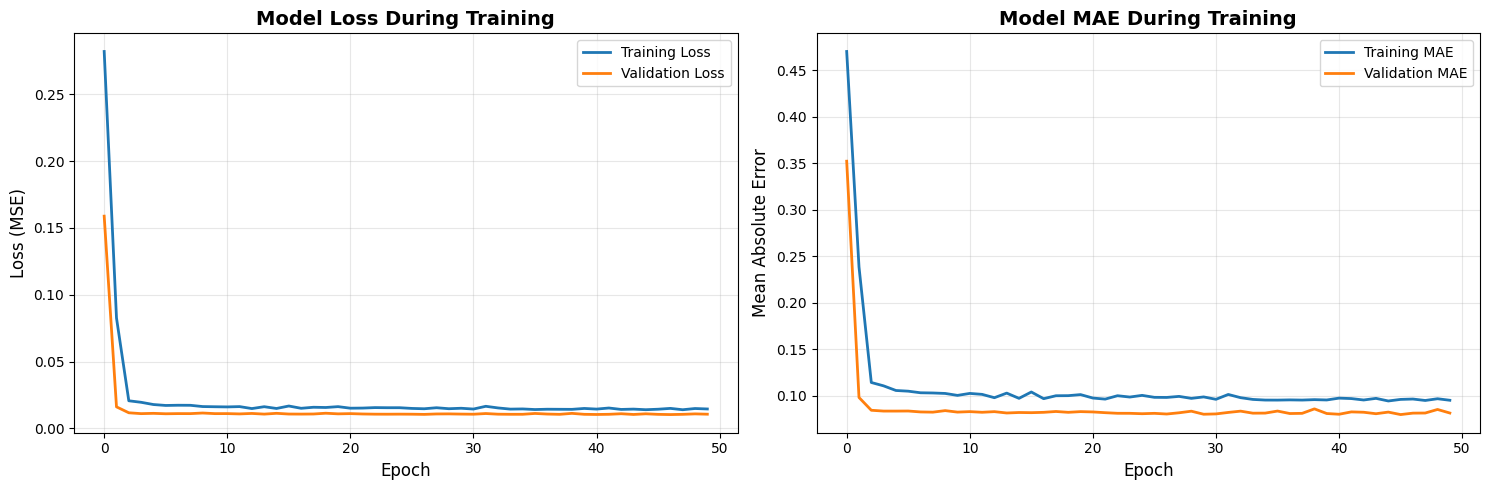

In [6]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_title('Model Loss During Training', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE plot
ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
ax2.set_title('Model MAE During Training', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Making Predictions

Now let's use our trained model to make predictions on the test set:

Test Set Performance:
Mean Squared Error (MSE): 0.010861
Root Mean Squared Error (RMSE): 0.104216
Mean Absolute Error (MAE): 0.085232


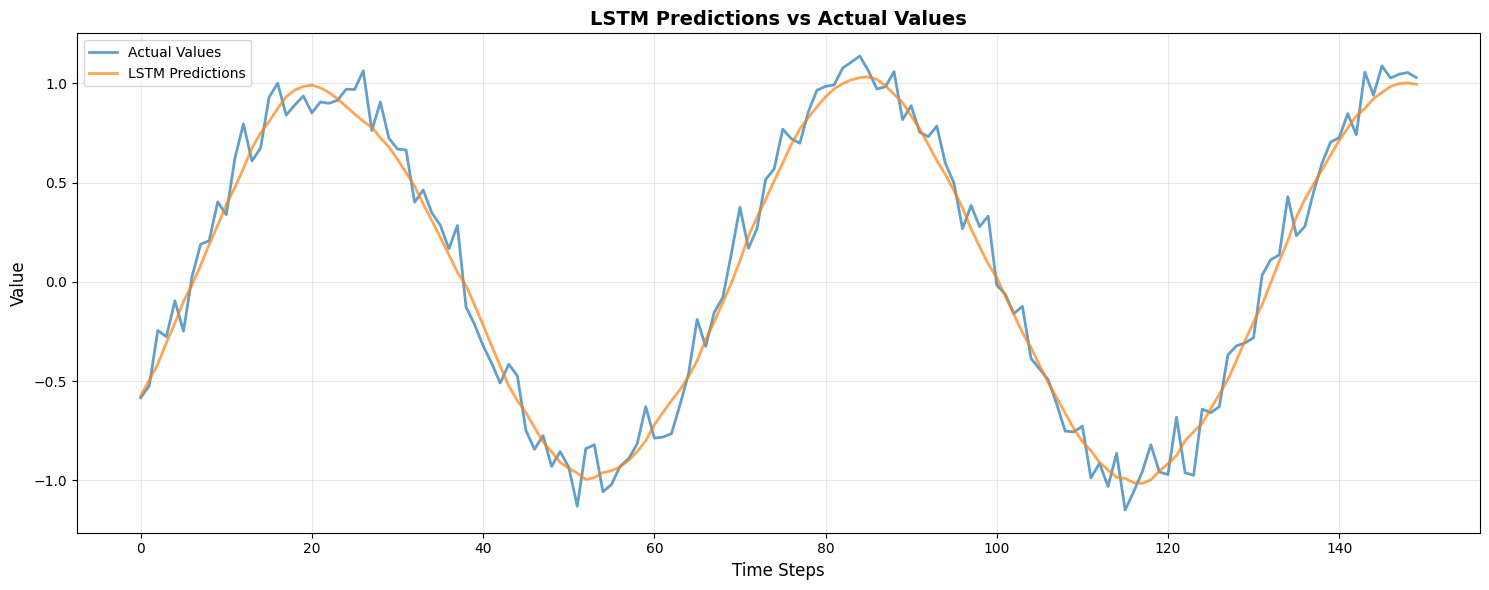

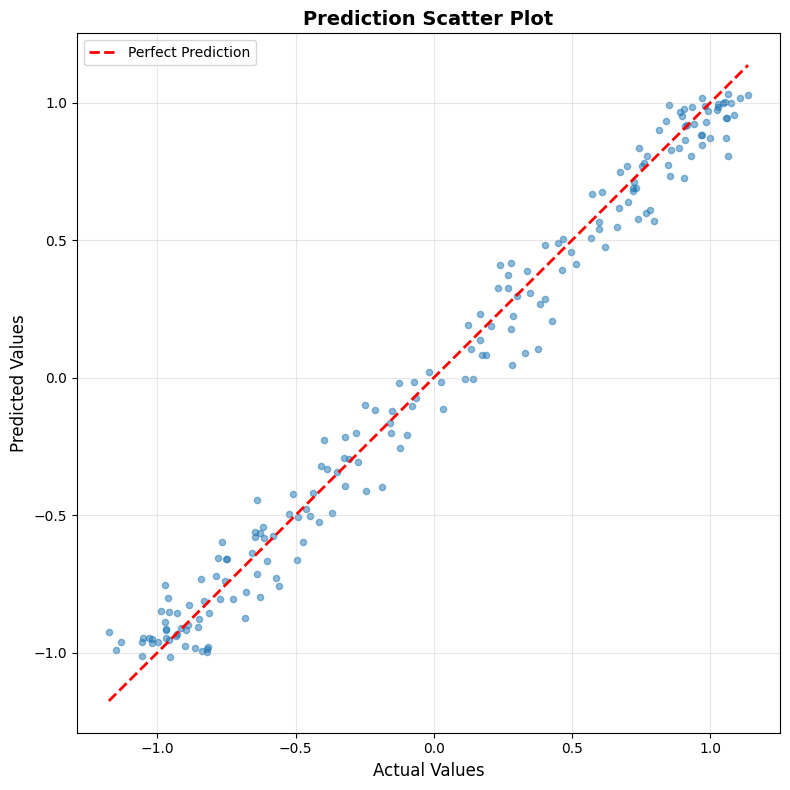

In [7]:
# Make predictions on test set
y_pred = model.predict(X_test, verbose=0)
y_pred = y_pred.flatten()

# Calculate error metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Test Set Performance:")
print("=" * 60)
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")

# Visualize predictions vs actual values
plt.figure(figsize=(15, 6))

# Plot a subset for clarity (ensure we don't exceed array size)
plot_range = min(150, len(y_test))
plt.plot(y_test[:plot_range], label='Actual Values', linewidth=2, alpha=0.7)
plt.plot(y_pred[:plot_range], label='LSTM Predictions', linewidth=2, alpha=0.7)

plt.title('LSTM Predictions vs Actual Values', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot of predictions vs actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.title('Prediction Scatter Plot', fontsize=14, fontweight='bold')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Hands-On Activity: Multi-Step Ahead Prediction

In real-world applications, we often want to predict multiple steps into the future. Let's implement a function that uses our trained LSTM to make multi-step predictions.

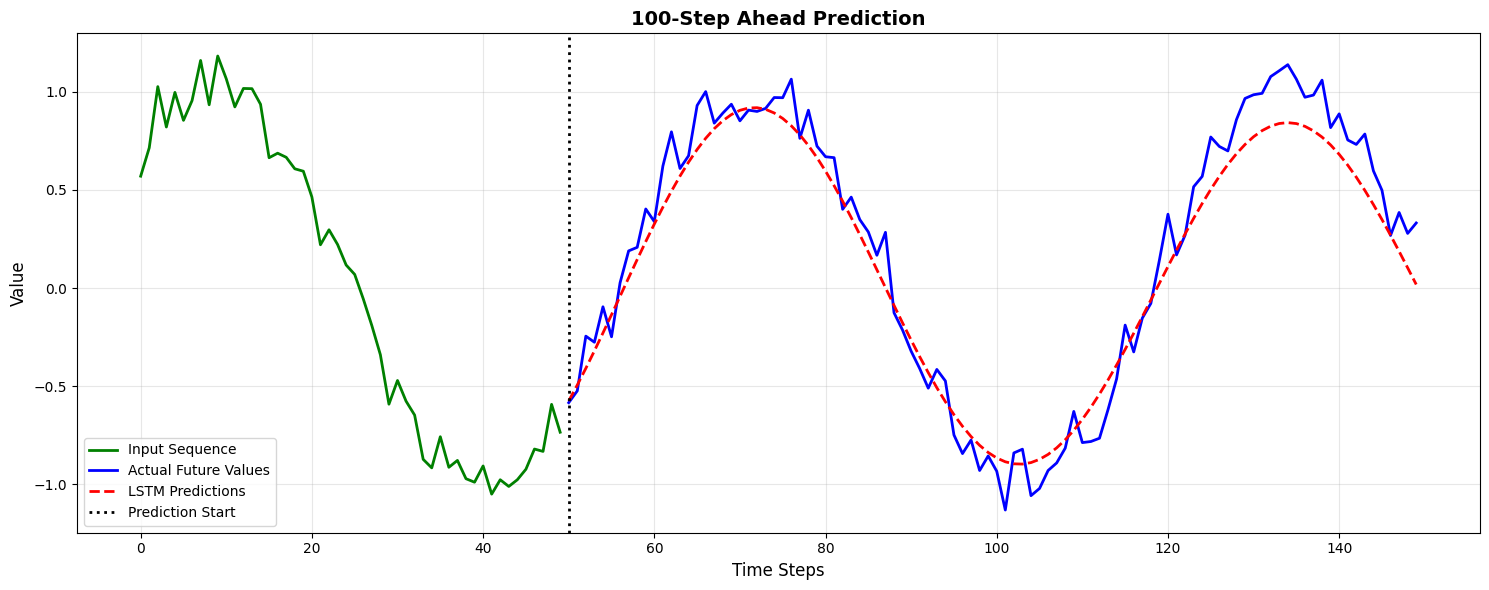

Multi-Step Prediction Performance (100 steps):
MAE: 0.122389
RMSE: 0.148348


In [8]:
def predict_multiple_steps(model, initial_sequence, n_steps_ahead):
    """
    Predict multiple steps ahead using LSTM
    
    Args:
        model: Trained LSTM model
        initial_sequence: Initial sequence to start predictions
        n_steps_ahead: Number of steps to predict into the future
    
    Returns:
        Array of predictions
    """
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for _ in range(n_steps_ahead):
        # Reshape for model input
        input_seq = current_sequence.reshape(1, current_sequence.shape[0], 1)
        
        # Predict next value
        next_pred = model.predict(input_seq, verbose=0)[0, 0]
        predictions.append(next_pred)
        
        # Update sequence: remove first value, add prediction
        current_sequence = np.append(current_sequence[1:], next_pred)
    
    return np.array(predictions)

# Test multi-step prediction
initial_sequence = X_test[0].flatten()  # Use first test sequence
n_steps_ahead = 100

# Make multi-step predictions
multi_step_preds = predict_multiple_steps(model, initial_sequence, n_steps_ahead)

# Get actual values for comparison
start_idx = train_size + n_steps
actual_values = data[start_idx:start_idx + n_steps_ahead]

# Visualize multi-step predictions
plt.figure(figsize=(15, 6))

plt.plot(range(len(initial_sequence)), initial_sequence, 
         label='Input Sequence', linewidth=2, color='green')
plt.plot(range(len(initial_sequence), len(initial_sequence) + len(actual_values)), 
         actual_values, label='Actual Future Values', linewidth=2, color='blue')
plt.plot(range(len(initial_sequence), len(initial_sequence) + len(multi_step_preds)), 
         multi_step_preds, label='LSTM Predictions', linewidth=2, 
         color='red', linestyle='--')

plt.axvline(x=len(initial_sequence), color='black', linestyle=':', 
            linewidth=2, label='Prediction Start')
plt.title(f'{n_steps_ahead}-Step Ahead Prediction', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate performance for multi-step prediction
multi_mae = mean_absolute_error(actual_values, multi_step_preds)
multi_rmse = np.sqrt(mean_squared_error(actual_values, multi_step_preds))

print(f"Multi-Step Prediction Performance ({n_steps_ahead} steps):")
print("=" * 60)
print(f"MAE: {multi_mae:.6f}")
print(f"RMSE: {multi_rmse:.6f}")

## Example 2: Stacked LSTM for Complex Patterns

For more complex sequences, we can stack multiple LSTM layers. Let's build a deeper model:

In [9]:
def build_stacked_lstm(input_shape, units=[50, 30], dropout_rate=0.2):
    """
    Build a stacked LSTM model with multiple LSTM layers
    
    Args:
        input_shape: Shape of input sequences
        units: List of units for each LSTM layer
        dropout_rate: Dropout rate
    
    Returns:
        Compiled Keras model
    """
    model = Sequential()
    
    # First LSTM layer (return sequences for next LSTM layer)
    model.add(LSTM(units=units[0], activation='tanh', 
                   return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    # Additional LSTM layers
    for i in range(1, len(units)):
        # Last LSTM layer doesn't return sequences
        return_seq = (i < len(units) - 1)
        model.add(LSTM(units=units[i], activation='tanh', 
                       return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Build stacked LSTM
stacked_model = build_stacked_lstm(input_shape, units=[50, 30], dropout_rate=0.2)

print("Stacked LSTM Model Architecture:")
print("=" * 60)
stacked_model.summary()

# Train stacked model
print("\nTraining Stacked LSTM...")
stacked_history = stacked_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    shuffle=False
)

# Evaluate stacked model
stacked_pred = stacked_model.predict(X_test, verbose=0).flatten()
stacked_mae = mean_absolute_error(y_test, stacked_pred)
stacked_rmse = np.sqrt(mean_squared_error(y_test, stacked_pred))

print("\nStacked LSTM Performance:")
print("=" * 60)
print(f"Test MAE: {stacked_mae:.6f}")
print(f"Test RMSE: {stacked_rmse:.6f}")

print("\nComparison:")
print("=" * 60)
print(f"Single LSTM MAE: {mae:.6f}")
print(f"Stacked LSTM MAE: {stacked_mae:.6f}")
print(f"Improvement: {((mae - stacked_mae) / mae * 100):.2f}%")

Stacked LSTM Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,151 (78.71 KB)

 Trainable params: 20,151 (78.71 KB)

 Non-trainable params: 0 (0.00 B)


Training Stacked LSTM...



Stacked LSTM Performance:
Test MAE: 0.085982
Test RMSE: 0.106322

Comparison:
Single LSTM MAE: 0.085232
Stacked LSTM MAE: 0.085982
Improvement: -0.88%


### Comparing Single vs Stacked LSTM

Let's visualize the difference in performance:

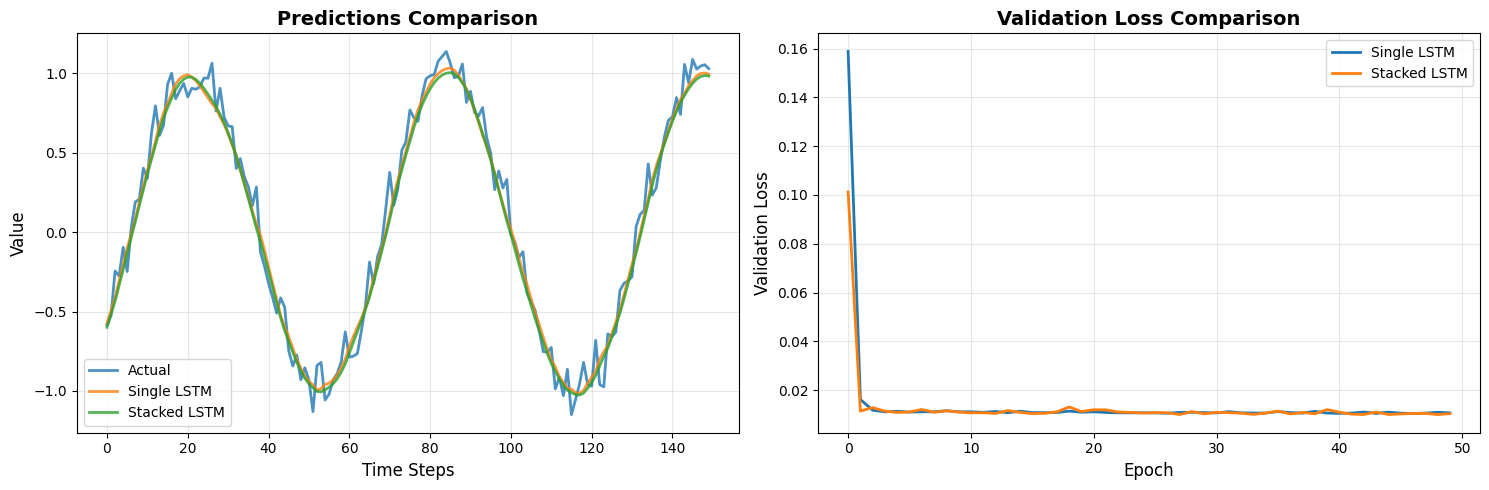

In [10]:
# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot predictions (ensure we don't exceed array size)
plot_range = min(150, len(y_test))
ax1.plot(y_test[:plot_range], label='Actual', linewidth=2, alpha=0.8)
ax1.plot(y_pred[:plot_range], label='Single LSTM', linewidth=2, alpha=0.8)
ax1.plot(stacked_pred[:plot_range], label='Stacked LSTM', linewidth=2, alpha=0.8)
ax1.set_title('Predictions Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Steps', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot training history comparison
ax2.plot(history.history['val_loss'], label='Single LSTM', linewidth=2)
ax2.plot(stacked_history.history['val_loss'], label='Stacked LSTM', linewidth=2)
ax2.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Loss', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Takeaways

Congratulations on completing Day 57! Here are the key points to remember:

1. **LSTMs solve the vanishing gradient problem** in vanilla RNNs through a gated architecture that controls information flow

2. **Three gates control the LSTM**:
   - **Forget gate**: Decides what information to discard from the cell state
   - **Input gate**: Decides what new information to add to the cell state
   - **Output gate**: Decides what information to output based on the cell state

3. **Cell state is the key**: The cell state provides a highway for gradients to flow through time with minimal modification, enabling learning of long-term dependencies

4. **Data preparation matters**: For sequence prediction, we need to structure data as (samples, time steps, features)

5. **Stacked LSTMs can improve performance** by learning hierarchical representations, but they also increase model complexity and training time

6. **Multi-step prediction is challenging**: Errors accumulate as we predict further into the future, making long-term forecasting difficult

7. **LSTMs are versatile**: They can be applied to time series forecasting, natural language processing, speech recognition, and many other sequential tasks

## Further Resources

To deepen your understanding of LSTM networks, explore these resources:

1. **Original LSTM Paper**: Hochreiter, S., & Schmidhuber, J. (1997). "Long Short-Term Memory". Neural Computation, 9(8), 1735-1780.
   - https://www.bioinf.jku.at/publications/older/2604.pdf

2. **Understanding LSTM Networks** by Christopher Olah:
   - https://colah.github.io/posts/2015-08-Understanding-LSTMs/
   - Excellent visual explanation of LSTM architecture

3. **TensorFlow LSTM Documentation**:
   - https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
   - Official documentation with detailed parameter descriptions

4. **The Unreasonable Effectiveness of Recurrent Neural Networks** by Andrej Karpathy:
   - http://karpathy.github.io/2015/05/21/rnn-effectiveness/
   - Great examples of what RNNs/LSTMs can do

5. **Sequence Models Course** by Andrew Ng (Coursera):
   - https://www.coursera.org/learn/nlp-sequence-models
   - Comprehensive course on RNNs, LSTMs, and sequence modeling

6. **Time Series Forecasting with LSTMs** (Keras Tutorial):
   - https://keras.io/examples/timeseries/
   - Practical examples of LSTM applications

### Practice Exercises

To solidify your understanding, try these exercises:

1. Apply LSTMs to real-world datasets like stock prices or weather data
2. Experiment with bidirectional LSTMs for sequence classification
3. Implement character-level text generation using LSTMs
4. Compare LSTM performance with GRU (which we'll cover in the next lesson)
5. Build a sentiment analysis model using LSTMs on text data

### Next Steps

In the upcoming lessons, we'll explore:
- **Day 58**: Gated Recurrent Units (GRU) and their comparison with LSTMs
- **Day 59**: Sequence-to-Sequence models for tasks like machine translation
- **Day 60**: Attention mechanisms and their role in modern deep learning

Keep practicing and exploring the fascinating world of sequence modeling!

In [11]:
# Final summary statistics
print("=" * 70)
print("LESSON 57 SUMMARY: LSTM Networks")
print("=" * 70)
print(f"\nSingle LSTM Model:")
print(f"  - Architecture: 1 LSTM layer (50 units) + Dense")
print(f"  - Parameters: {trainable_params:,}")
print(f"  - Test MAE: {mae:.6f}")
print(f"  - Test RMSE: {rmse:.6f}")
print(f"\nStacked LSTM Model:")
print(f"  - Architecture: 2 LSTM layers (50, 30 units) + Dense")
print(f"  - Test MAE: {stacked_mae:.6f}")
print(f"  - Test RMSE: {stacked_rmse:.6f}")
print(f"\nYou've successfully completed Day 57!")
print(f"You now understand LSTM architecture and can apply it to sequence tasks.")
print("=" * 70)

LESSON 57 SUMMARY: LSTM Networks

Single LSTM Model:
  - Architecture: 1 LSTM layer (50 units) + Dense
  - Parameters: 10,451
  - Test MAE: 0.085232
  - Test RMSE: 0.104216

Stacked LSTM Model:
  - Architecture: 2 LSTM layers (50, 30 units) + Dense
  - Test MAE: 0.085982
  - Test RMSE: 0.106322

You've successfully completed Day 57!
You now understand LSTM architecture and can apply it to sequence tasks.
